<a href="https://colab.research.google.com/github/ldsAS/Tibame-AI-Learning/blob/main/LAB_HousePrice_%E4%BD%9C%E6%A5%AD(%E8%A8%93%E7%B7%B4%26%E6%8E%A8%E7%90%86).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HousePrice預測 回歸問題
(推理階段直接放在此同篇下方)

# [ 訓練階段 ]

In [2]:
#載入訓練用資料
import pandas as pd
import numpy as np
data = pd.read_csv('../content/HousePrice_train.csv')
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,255,20,RL,70.0,8400,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,145000
1,1067,60,RL,59.0,7837,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2009,WD,Normal,178000
2,639,30,RL,67.0,8777,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,5,2008,WD,Normal,85000
3,800,50,RL,60.0,7200,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,6,2007,WD,Normal,175000
4,381,50,RL,50.0,5000,Pave,Pave,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,127000


In [3]:
#列出欄位名稱
data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [4]:
# 刪除 price為空值的資料列
data = data.dropna(subset=['SalePrice'])

# 自動前處理 (自製)

In [5]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
class AutoPreprocess:
    def __init__(self):
        self.scaler = {}
        self.fillna_value = {}
        self.onehotencode_value = {}
        self.field_names = []
        self.final_field_names = []

    def fit(self, data, field_names):
        self.__init__()
        self.field_names = field_names

        for fname in field_names:
            #自動補空值
            if (data[fname].dtype == object) or (data[fname].dtype == str): #字串型態欄位
                self.fillna_value[fname] = data[fname].mode()[0] #補眾數
                # self.fillna_value[fname] = 'np.nan'
                # self.fillna_value[fname] = np.nan # 維持空值
            elif data[fname].dtype == bool: #布林型態
                self.fillna_value[fname] = data[fname].mode()[0] #補眾數
            else: # 數字型態
                self.fillna_value[fname] = data[fname].median()  #補中位數

            #自動尺度轉換(scaling)
            if (data[fname].dtype == object) or (data[fname].dtype == str): #字串型態欄位
                pass #不用轉換
            elif data[fname].dtype == bool: #布林型態
                pass #不用轉換
            else: # 數字型態
                vc = data[fname].value_counts()
                if data[fname].isin([0, 1]).all(): #當數值只有0跟1
                    pass #不用轉換
                elif pd.api.types.is_integer_dtype(data[fname]) and data[fname].nunique() <= 10: #是否簡單的整數型類別且數量小於10
                    self.scaler[fname] = MinMaxScaler()
                    self.scaler[fname].fit(data[[fname]])
                else: #其他的數字型態
                    self.scaler[fname] = StandardScaler()
                    self.scaler[fname].fit(data[[fname]])


            #自動編碼
            if (data[fname].dtype == object) or (data[fname].dtype == str): #字串型態欄位, onehotencode
                field_value = data[fname].value_counts().index
                self.onehotencode_value[fname] = field_value
                for value in field_value:
                    fn = fname+"_"+value
                    # data[fn] = (data[fname] == value).astype('int8')
                    self.final_field_names.append(fn)
            elif data[fname].dtype == bool: #布林型態 轉成0跟1
                # data[fname] = data[fname].astype(int)
                self.final_field_names.append(fname)
            else: # 數字型態 不用重新編碼
                self.final_field_names.append(fname)

        return

    def transform(self, data):
        #如果輸入的data是dict，要先轉成dataframe
        if isinstance(data, dict):
            for fname in self.field_names:
                if fname in data:
                    data[fname] = [data[fname]]
                else:
                    data[fname] = [np.nan]
            data = pd.DataFrame(data)
        else: #將資料複製一份，不修改原本的資料
            data = data.copy()

        for fname in self.field_names:
            #自動補空值
            if data[fname].isnull().any(): #有空值
                # if fname in self.fillna_value:
                    data[fname] = data[fname].fillna(self.fillna_value[fname])


            #自動尺度轉換(scaling)
            if fname in self.scaler:
                data[fname] = self.scaler[fname].transform(data[[fname]])

            #自動編碼
            if (data[fname].dtype == object) or (data[fname].dtype == str): #字串型態欄位, onehotencode
                if fname in self.onehotencode_value:
                    field_value = self.onehotencode_value[fname]
                for value in field_value:
                    fn = fname+"_"+value
                    data[fn] = (data[fname] == value).astype('int8')
            elif data[fname].dtype == bool: #布林型態 轉成0跟1
                data[fname] = data[fname].astype(int)
            else: # 數字型態 不用重新編碼
                pass
        return data[self.final_field_names]

    def save(self, file_name):
        with open(file_name, "wb") as f:
            pickle.dump(self, f)

    @staticmethod
    def load(file_name):
        with open(file_name, "rb") as f:
            return pickle.load(f)

In [ ]:
# 建議要把環境條件記錄下來
!pip list

Package                               Version
------------------------------------- -------------------
absl-py                               1.4.0
accelerate                            1.7.0
aiofiles                              24.1.0
aiohappyeyeballs                      2.6.1
aiohttp                               3.11.15
aiosignal                             1.3.2
alabaster                             1.0.0
albucore                              0.0.24
albumentations                        2.0.8
ale-py                                0.11.1
altair                                5.5.0
annotated-types                       0.7.0
antlr4-python3-runtime                4.9.3
anyio                                 4.9.0
argon2-cffi                           25.1.0
argon2-cffi-bindings                  21.2.0
array_record                          0.7.2
arviz                                 0.21.0
astropy                               7.1.0
astropy-iers-data                     0.2025.6.16.0.

In [ ]:
# 將目前的python環境存成requirements
!pip freeze > requirements.txt

In [ ]:
# # AutoPreprocess Example
# ####################################################
# # Train Step
# mydata = pd.read_csv('../data/Automobile_Train.csv')
# ap = AutoPreprocess()
# ap.fit(mydata, ['symboling', 'Normalized-losses', 'make', 'Fuel-type', 'aspiration',
#        'Num-of-doors', 'Body-style', 'Drive-wheels', 'Engine-location',
#        'Wheel-base', 'length', 'width', 'height', 'Curb-weight', 'Engine-type',
#        'Num-of-cylinders', 'Engine-size', 'Fuel-system', 'bore', 'stroke',
#        'Compression-ratio', 'horsepower', 'Peak-rpm', 'City-mpg',
#        'Highway-mpg'])
# ap.save("C:/DATA/test.bin")

# ####################################################
# # Test and inference
# ap2 = AutoPreprocess.load("C:/DATA/test.bin")
# d2 = ap2.transform(mydata) #Pandas Dataframe
# d2.head()

# ####################################################
# # Test and inference with one record
# ap2 = AutoPreprocess.load("C:/DATA/test.bin")
# data_dict = {"symboling":1, "aspiration":"std"}
# d2 = ap2.transform(data_dict) #Python Dict
# print(d2)


# 前處理

In [6]:
ap = AutoPreprocess()
ap.fit(data, ['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC',
       'Fence', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition'])
ap.save("preprocess.bin")

X = ap.transform(data)
y = data['SalePrice']

/tmp/ipython-input-5-2495950163.py:91: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[fn] = (data[fname] == value).astype('int8')
/tmp/ipython-input-5-2495950163.py:91: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[fn] = (data[fname] == value).astype('int8')
/tmp/ipython-input-5-2495950163.py:91: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

# 訓練模型 : 方法一

In [7]:
from sklearn.model_selection import train_test_split
# 分割資料成訓練組跟驗證組
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=0)

In [8]:
# 訓練模型
# from sklearn.neural_network import MLPRegressor
# model = MLPRegressor(hidden_layer_sizes=(200,), max_iter=200, random_state=42)

# from sklearn.tree import DecisionTreeRegressor
# model = DecisionTreeRegressor()

from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()

model.fit(X_train, y_train)

RandomForestRegressor()

訓練組 R2: 0.9756173172820094
驗證組 R2: 0.8702480951890661


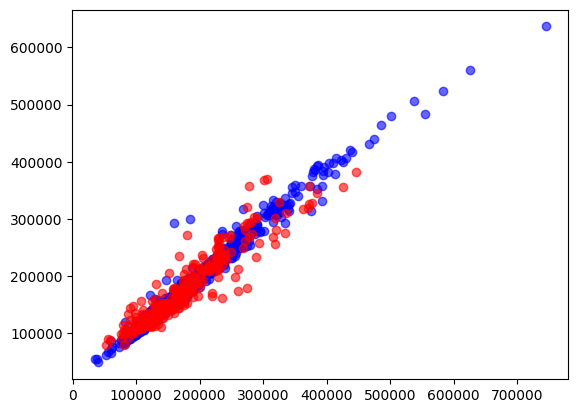

In [9]:
# 驗證模型
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
y_pred = model.predict(X_train)
r2 = r2_score(y_train, y_pred)
print("訓練組 R2:", r2)
plt.scatter(y_train, y_pred, alpha=0.6, color='b')
# plt.show()

y_pred = model.predict(X_valid)
r2 = r2_score(y_valid, y_pred)
print("驗證組 R2:", r2)
plt.scatter(y_valid, y_pred, alpha=0.6, color='r')
plt.show()


In [10]:
# 儲存模型
# 建議每次訓練就存一次，存成表
import pickle

with open("model.bin", "wb") as f:
    pickle.dump(model, f)


# RandomizedSearchCV版訓練 : 方法二

### SVR

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.svm import SVR

param_grid = [
    {"kernel": ["linear"],"C":[0.1,1,10,100,1000]},
    {"kernel": ["poly"], "degree": [2, 3],"C":[0.1,1,10,100,100],"gamma":["scale", "auto"]},
    {"kernel": ["rbf"],"C":[0.1,1,10,100,100],"gamma":["scale", "auto"]},
]

model = SVR()

search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, scoring="r2")
search.fit(X, y)

RandomizedSearchCV(estimator=SVR(),
                   param_distributions=[{'C': [0.1, 1, 10, 100, 1000],
                                         'kernel': ['linear']},
                                        {'C': [0.1, 1, 10, 100, 100],
                                         'degree': [2, 3],
                                         'gamma': ['scale', 'auto'],
                                         'kernel': ['poly']},
                                        {'C': [0.1, 1, 10, 100, 100],
                                         'gamma': ['scale', 'auto'],
                                         'kernel': ['rbf']}],
                   scoring='r2')

In [ ]:
search.best_params_

{'kernel': 'poly', 'gamma': 'scale', 'degree': 2, 'C': 100}

In [ ]:
search.cv_results_

{'mean_fit_time': array([0.19719443, 0.16237383, 0.14301662, 0.14559364, 0.14402428,
        0.15686159, 0.134271  , 0.13406048, 0.17944036, 0.20205321]),
 'std_fit_time': array([0.00854524, 0.03056147, 0.00280426, 0.00588257, 0.00526402,
        0.03980916, 0.00650501, 0.00277243, 0.02695814, 0.00452429]),
 'mean_score_time': array([0.04819655, 0.03552351, 0.07839375, 0.07532225, 0.07638402,
        0.03227382, 0.03386564, 0.03280206, 0.04451241, 0.12223773]),
 'std_score_time': array([0.00158368, 0.00607479, 0.00599419, 0.00209247, 0.00048326,
        0.00027821, 0.00150695, 0.00080022, 0.00627352, 0.0039163 ]),
 'param_kernel': masked_array(data=['poly', 'poly', 'rbf', 'rbf', 'rbf', 'poly', 'poly',
                    'poly', 'poly', 'rbf'],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value=np.str_('?'),
             dtype=object),
 'param_gamma': masked_array(data=['scale', 'auto', 'scale', 'scale', 'au

In [ ]:
search.best_estimator_

SVR(C=100, degree=2, kernel='poly')

In [ ]:
#儲存模型
import pickle

with open("model2.bin", "wb") as f:
    pickle.dump(search.best_estimator_, f)


R2: 0.13336507096890493


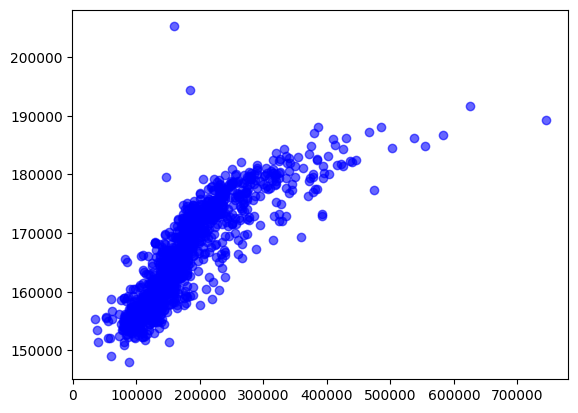

In [ ]:
# 驗證模型
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
model = search.best_estimator_
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)
print("R2:", r2)
plt.scatter(y, y_pred, alpha=0.6, color='b')
plt.show()


# 評估欄位影響度 Permutation Importance

In [12]:
# 這是個有點偷吃步的方法(在欄位更動的情況下，將欄位打亂後重新訓練)
# 這是個可以將訓練好但可解釋性較低的模型，找出欄位影響力(也有人透過此方法再建出專家系統)
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import r2_score


def getFieldImpact(model, x, y, score):
    prediction = model.predict(x)
    full_field_score = score(y, prediction)
    impact = {}
    for column_name in x.columns:
        x2 = x.copy()
        column_data = x2[column_name].to_numpy()
        np.random.shuffle(column_data)
        x2[column_name] = column_data
        p2 = model.predict(x2)
        score2 = score(y, p2)
        impact[column_name] = (full_field_score - score2) / full_field_score
    return impact



impact = getFieldImpact(model, X, y, r2_score)
impact

{'Id': 0.0018195875221400785,
 'MSSubClass': 0.0012401464710810428,
 'MSZoning_RL': 0.00014142264001266476,
 'MSZoning_RM': 0.0004547084925785398,
 'MSZoning_FV': 3.488150702222361e-05,
 'MSZoning_RH': 3.7492493058058287e-06,
 'MSZoning_C (all)': 7.442914740749604e-05,
 'LotFrontage': 0.005452373572540534,
 'LotArea': 0.014392483828939937,
 'Street_Pave': 1.8870672316524353e-08,
 'Street_Grvl': -7.290651362604824e-09,
 'Alley_Grvl': 2.2129375274080753e-05,
 'Alley_Pave': 2.9834618054846525e-05,
 'LotShape_Reg': 0.0002583571288371572,
 'LotShape_IR1': 0.00014934064130404899,
 'LotShape_IR2': 0.00015564604941375917,
 'LotShape_IR3': 3.803007978368573e-05,
 'LandContour_Lvl': 0.0004708385920292788,
 'LandContour_Bnk': 0.0010689969132877642,
 'LandContour_HLS': 0.00016787506128330948,
 'LandContour_Low': 4.2655270485852084e-05,
 'Utilities_AllPub': 8.20147581899998e-08,
 'Utilities_NoSeWa': 0.0,
 'LotConfig_Inside': 8.173702315887504e-05,
 'LotConfig_Corner': 0.00012332429790056743,
 'LotC

In [ ]:
# sklearn版的permutation_importance
from sklearn.inspection import permutation_importance
r = permutation_importance(model, X, y,
                           n_repeats=30,
                           random_state=0)
r


{'importances_mean': array([ 5.18374854e-05,  5.20961660e-04,  5.22785380e-04,  4.47597511e-04,
         2.87391345e-05,  3.11871521e-06,  8.86403007e-07,  2.43152304e-03,
         2.89906018e-03,  7.98752981e-06,  2.60115864e-07,  1.34780040e-04,
        -1.46963171e-06,  3.65780343e-04,  5.35246842e-04,  3.10535688e-05,
         1.79692626e-06, -9.34319812e-06,  1.65284662e-05,  2.54211238e-05,
         9.19881797e-06,  3.79818321e-06,  3.83420726e-08, -5.71360341e-05,
        -7.35429732e-06,  7.31717123e-05, -3.31614557e-07,  1.48753728e-07,
        -5.58162609e-05,  1.37666441e-05,  7.28593576e-06,  1.94135762e-04,
         4.20664048e-05,  1.06060864e-04,  1.18304134e-04,  7.40790660e-05,
         3.38941978e-06,  2.07936256e-05,  3.05548241e-04,  3.82830049e-05,
         3.12146774e-05,  1.76130289e-05, -6.47891482e-07,  6.91404873e-06,
         1.14129533e-04,  1.87105504e-05,  1.87185657e-05,  2.08603498e-06,
         2.88634343e-05,  7.26086286e-06,  4.18158491e-07,  8.452762

# [ 推理階段 ]

# 測試

In [13]:
#載入測試用資料
import pandas as pd
import numpy as np
data = pd.read_csv('../content/HousePrice_test.csv')
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,893,20,RL,70.0,8414,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2006,WD,Normal,154500
1,1106,60,RL,98.0,12256,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,325000
2,414,30,RM,56.0,8960,Pave,Grvl,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2010,WD,Normal,115000
3,523,50,RM,50.0,5000,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,10,2006,WD,Normal,159000
4,1037,20,RL,89.0,12898,Pave,NaN,IR1,HLS,AllPub,...,0,NaN,NaN,NaN,0,9,2009,WD,Normal,315500


In [14]:
# 刪除 price為空值的資料列
data = data.dropna(subset=['SalePrice'])

In [15]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
class AutoPreprocess:
    def __init__(self):
        self.scaler = {}
        self.fillna_value = {}
        self.onehotencode_value = {}
        self.field_names = []
        self.final_field_names = []

    def fit(self, data, field_names):
        self.__init__()
        self.field_names = field_names

        for fname in field_names:
            #自動補空值
            if (data[fname].dtype == object) or (data[fname].dtype == str): #字串型態欄位
                # self.fillna_value[fname] = data[fname].mode()[0] #補眾數
                self.fillna_value[fname] = 'np.nan'
                # self.fillna_value[fname] = np.nan # 維持空值
            elif data[fname].dtype == bool: #布林型態
                self.fillna_value[fname] = data[fname].mode()[0] #補眾數
            else: # 數字型態
                self.fillna_value[fname] = data[fname].median()  #補中位數

            #自動尺度轉換(scaling)
            if (data[fname].dtype == object) or (data[fname].dtype == str): #字串型態欄位
                pass #不用轉換
            elif data[fname].dtype == bool: #布林型態
                pass #不用轉換
            else: # 數字型態
                vc = data[fname].value_counts()
                if data[fname].isin([0, 1]).all(): #當數值只有0跟1
                    pass #不用轉換
                elif pd.api.types.is_integer_dtype(data[fname]) and data[fname].nunique() <= 10: #是否簡單的整數型類別且數量小於10
                    self.scaler[fname] = MinMaxScaler()
                    self.scaler[fname].fit(data[[fname]])
                else: #其他的數字型態
                    self.scaler[fname] = StandardScaler()
                    self.scaler[fname].fit(data[[fname]])


            #自動編碼
            if (data[fname].dtype == object) or (data[fname].dtype == str): #字串型態欄位, onehotencode
                field_value = data[fname].value_counts().index
                self.onehotencode_value[fname] = field_value
                for value in field_value:
                    fn = fname+"_"+value
                    # data[fn] = (data[fname] == value).astype('int8')
                    self.final_field_names.append(fn)
            elif data[fname].dtype == bool: #布林型態 轉成0跟1
                # data[fname] = data[fname].astype(int)
                self.final_field_names.append(fname)
            else: # 數字型態 不用重新編碼
                self.final_field_names.append(fname)

        return

    def transform(self, data):
        #如果輸入的data是dict，要先轉成dataframe
        if isinstance(data, dict):
            for fname in self.field_names:
                if fname in data:
                    data[fname] = [data[fname]]
                else:
                    data[fname] = [np.nan]
            data = pd.DataFrame(data)
        else: #將資料複製一份，不修改原本的資料
            data = data.copy()

        for fname in self.field_names:
            #自動補空值
            if data[fname].isnull().any(): #有空值
                # if fname in self.fillna_value:
                    data[fname] = data[fname].fillna(self.fillna_value[fname])


            #自動尺度轉換(scaling)
            if fname in self.scaler:
                data[fname] = self.scaler[fname].transform(data[[fname]])

            #自動編碼
            if (data[fname].dtype == object) or (data[fname].dtype == str): #字串型態欄位, onehotencode
                if fname in self.onehotencode_value:
                    field_value = self.onehotencode_value[fname]
                for value in field_value:
                    fn = fname+"_"+value
                    data[fn] = (data[fname] == value).astype('int8')
            elif data[fname].dtype == bool: #布林型態 轉成0跟1
                data[fname] = data[fname].astype(int)
            else: # 數字型態 不用重新編碼
                pass
        return data[self.final_field_names]

    def save(self, file_name):
        with open(file_name, "wb") as f:
            pickle.dump(self, f)

    @staticmethod
    def load(file_name):
        with open(file_name, "rb") as f:
            return pickle.load(f)

In [16]:
# 載入前處理模型並轉換資料
ap = AutoPreprocess.load("preprocess.bin")
X = ap.transform(data)
y = data['SalePrice']

/tmp/ipython-input-15-1660026326.py:91: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[fn] = (data[fname] == value).astype('int8')
/tmp/ipython-input-15-1660026326.py:91: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[fn] = (data[fname] == value).astype('int8')
/tmp/ipython-input-15-1660026326.py:91: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get 

In [17]:
# 載入模型
f =  open("model.bin", "rb")
model =  pickle.load(f)
model

RandomForestRegressor()

測試組 R2: 0.8730648134892286


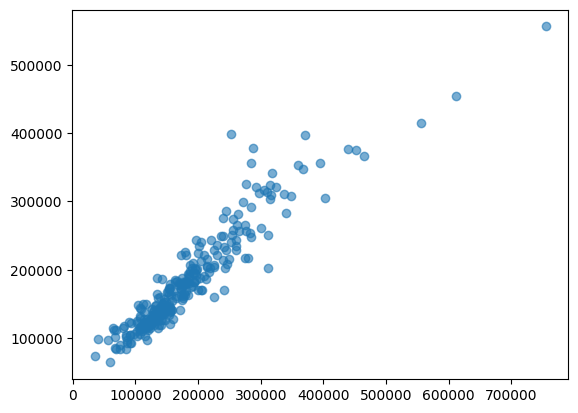

In [18]:
# 驗證模型
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)
print("測試組 R2:", r2)
plt.scatter(y, y_pred, alpha=0.6)
plt.show()

# 推理

In [19]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
class AutoPreprocess:
    def __init__(self):
        self.scaler = {}
        self.fillna_value = {}
        self.onehotencode_value = {}
        self.field_names = []
        self.final_field_names = []

    def fit(self, data, field_names):
        self.__init__()
        self.field_names = field_names

        for fname in field_names:
            #自動補空值
            if (data[fname].dtype == object) or (data[fname].dtype == str): #字串型態欄位
                # self.fillna_value[fname] = data[fname].mode()[0] #補眾數
                self.fillna_value[fname] = 'np.nan'
                # self.fillna_value[fname] = np.nan # 維持空值
            elif data[fname].dtype == bool: #布林型態
                self.fillna_value[fname] = data[fname].mode()[0] #補眾數
            else: # 數字型態
                self.fillna_value[fname] = data[fname].median()  #補中位數

            #自動尺度轉換(scaling)
            if (data[fname].dtype == object) or (data[fname].dtype == str): #字串型態欄位
                pass #不用轉換
            elif data[fname].dtype == bool: #布林型態
                pass #不用轉換
            else: # 數字型態
                vc = data[fname].value_counts()
                if data[fname].isin([0, 1]).all(): #當數值只有0跟1
                    pass #不用轉換
                elif pd.api.types.is_integer_dtype(data[fname]) and data[fname].nunique() <= 10: #是否簡單的整數型類別且數量小於10
                    self.scaler[fname] = MinMaxScaler()
                    self.scaler[fname].fit(data[[fname]])
                else: #其他的數字型態
                    self.scaler[fname] = StandardScaler()
                    self.scaler[fname].fit(data[[fname]])


            #自動編碼
            if (data[fname].dtype == object) or (data[fname].dtype == str): #字串型態欄位, onehotencode
                field_value = data[fname].value_counts().index
                self.onehotencode_value[fname] = field_value
                for value in field_value:
                    fn = fname+"_"+value
                    # data[fn] = (data[fname] == value).astype('int8')
                    self.final_field_names.append(fn)
            elif data[fname].dtype == bool: #布林型態 轉成0跟1
                # data[fname] = data[fname].astype(int)
                self.final_field_names.append(fname)
            else: # 數字型態 不用重新編碼
                self.final_field_names.append(fname)

        return

    def transform(self, data):
        #如果輸入的data是dict，要先轉成dataframe
        if isinstance(data, dict):
            for fname in self.field_names:
                if fname in data:
                    data[fname] = [data[fname]]
                else:
                    data[fname] = [np.nan]
            data = pd.DataFrame(data)
        else: #將資料複製一份，不修改原本的資料
            data = data.copy()

        for fname in self.field_names:
            #自動補空值
            if data[fname].isnull().any(): #有空值
                # if fname in self.fillna_value:
                    data[fname] = data[fname].fillna(self.fillna_value[fname])


            #自動尺度轉換(scaling)
            if fname in self.scaler:
                data[fname] = self.scaler[fname].transform(data[[fname]])

            #自動編碼
            if (data[fname].dtype == object) or (data[fname].dtype == str): #字串型態欄位, onehotencode
                if fname in self.onehotencode_value:
                    field_value = self.onehotencode_value[fname]
                for value in field_value:
                    fn = fname+"_"+value
                    data[fn] = (data[fname] == value).astype('int8')
            elif data[fname].dtype == bool: #布林型態 轉成0跟1
                data[fname] = data[fname].astype(int)
            else: # 數字型態 不用重新編碼
                pass
        return data[self.final_field_names]

    def save(self, file_name):
        with open(file_name, "wb") as f:
            pickle.dump(self, f)

    @staticmethod
    def load(file_name):
        with open(file_name, "rb") as f:
            return pickle.load(f)

In [24]:
data_dcit = {
    "Street" : "Pave",
    "Utilities" : "AllPub",
    "SaleType" : "WD",
    "MSZoning" : "RL",
    "SaleCondition" : "Normal"
}

In [25]:
# 載入前處理模型並轉換資料
ap = AutoPreprocess.load("preprocess.bin")
X = ap.transform(data_dcit)

/tmp/ipython-input-19-1660026326.py:91: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[fn] = (data[fname] == value).astype('int8')
/tmp/ipython-input-19-1660026326.py:91: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[fn] = (data[fname] == value).astype('int8')
/tmp/ipython-input-19-1660026326.py:91: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get 

In [26]:
# 載入模型
f =  open("model.bin", "rb")
model =  pickle.load(f)
model

RandomForestRegressor()

In [27]:
y_pred = model.predict(X)
y_pred

array([157792.67])